In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD,PCA,RandomizedPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from nltk.stem.porter import PorterStemmer

from collections import Counter
import re
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as col
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer

from sklearn.pipeline import Pipeline
import nltk

from datetime import date, timedelta,datetime
import calendar
from isoweek import Week
import seaborn as sns
from stop_words import get_stop_words
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

sns.set_style("whitegrid")
sns.set_context("poster")
np.set_printoptions(precision=3,suppress=True)

from  config import *

In [2]:
def create_content_df():    
    authors = pd.read_csv(DATA_PATH+"authors_id.csv",index_col=0)
    authors=authors[['id','displayName']]
    df = pd.read_csv(DATA_PATH+"all_content.csv")
    stop_words_en = get_stop_words('en')
    df = pd.merge(df,authors,left_on='author_id',right_on='id',how='inner')
    df=df[['displayName','content','collection_id','created_at']]
    df.columns = ['author_name','content','collection_id','created_at']
    return df

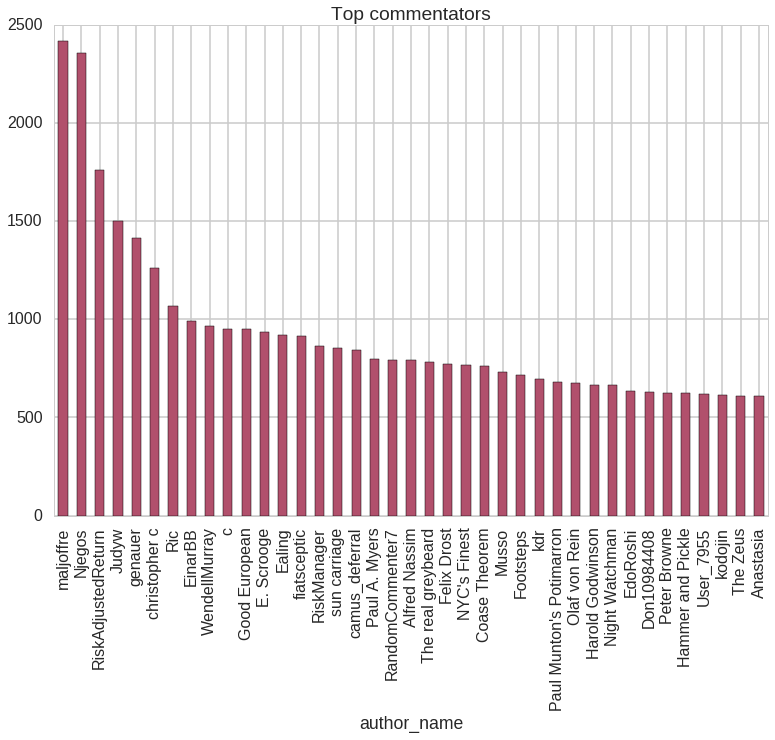

In [3]:
df = create_content_df()
groupy = df.groupby('author_name').count().sort_values(by='content',ascending=False)
groupy.content[groupy.content>600].plot(kind='bar',color=SINGLE_COLOR, title="Top commentators")

### Text preprocessing

#### Remove html tags and others

In [4]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

#### Create a Stemming tokenizer with Porter's algo.

In [5]:
porter = PorterStemmer()
def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

#### Stopwords

In [6]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/ramon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Filter on top commentators

In [7]:
def get_list_of_top_commentators(df_content):
    groupy = df_content.groupby('author_name').count().sort_values(by='content',ascending=False)
    top_commentators =  groupy.content[groupy.content>700].index.tolist()
    top_commentators = list(set(top_commentators) - set(['genauer','c','camus_deferral']))
    
    df_top_commentators =  pd.DataFrame(top_commentators).reset_index()
    df_top_commentators.columns=['author_index','author_name']
    
    return df_top_commentators

#### Only preprocess text

In [8]:
def preprocess_text(df_content):
    top_commentators = get_list_of_top_commentators(df_content)
    df = pd.merge(df_content,top_commentators,on='author_name',how='right')
    df['preprocessed_content'] = df.content.apply(preprocessor)
    df = df[['author_index','author_name','content']]
    return df
    

#### Aggregate comments per authors and preprocess text

In [9]:
def concat_content_per_author_and_preprocess(df_content):
    df = preprocess_text(df_content)
    df = df.groupby(['author_name','author_index']).agg({'content':lambda x:x.str.cat()})
    return df.reset_index()

#### Prepare data

In [10]:
def get_X_y_labels(df_comments):
    X = df_comments.content.values
    y = df_comments.author_index.values
    labels = df_comments.author_name.values
    return X,y,labels

### TFIDF

In [11]:
def get_vectorized_text(X,ngram_range=(1,1),max_features=None):
    pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range=ngram_range,tokenizer=tokenizer_porter,stop_words=stop,max_features=max_features)),
                         ('tfidf', TfidfTransformer())]) 
    return pipeline.fit_transform(X).todense()

#### Decomposition with PCA

In [12]:
df_comments_agg = concat_content_per_author_and_preprocess(df)
X,y,labels = get_X_y_labels(df_comments_agg)
X_vectorized = get_vectorized_text(X,ngram_range=(2,2))
pca = PCA(n_components=2).fit(X_vectorized)

print pca.explained_variance_ratio_.sum()
print pca.explained_variance_ratio_*100

0.0941908396702
[ 4.719  4.7  ]


/home/ramon/anaconda2/lib/python2.7/site-packages/matplotlib/patches.py:107: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


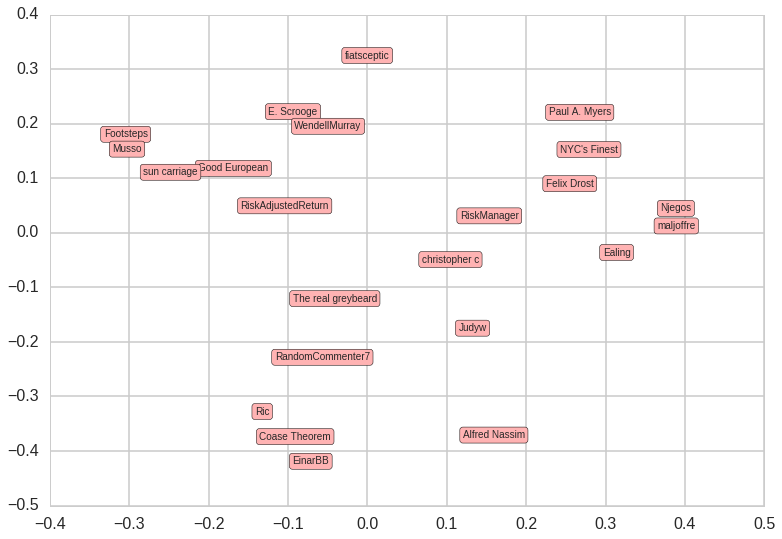

In [13]:
cmap = cm.get_cmap('Spectral')
data2D = pca.transform(X_vectorized)
plt.scatter(data2D[:,0], data2D[:,1], c=y,cmap=cmap,s=1,edgecolors=None,alpha=0.3)
for i, txt in enumerate(labels.tolist()):
    plt.annotate(txt, (data2D[i,0]+.0003,data2D[i,1]+.0008),fontsize=10,verticalalignment='top',horizontalalignment='left',
                bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7),facecolor='r',color='black',alpha=1))

#### Decomposition with LDA (Linear Discriminant Analysis)
As the data are labeled, we can give a try to reduce the dimensionality in a supervised way :

In [25]:
df_comments = preprocess_text(df)
df_comments = df_comments[df_comments.author_name.isin(['Njegos','The real greybeard','Judyw','Ric'])]
df_comments.shape
X,y,labels = get_X_y_labels(df_comments)
X_vectorized = get_vectorized_text(X,max_features=2000,ngram_range=(2,2))

In [15]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print "BEST PARAMS", gs.best_params_
    best = gs.best_estimator_
    return best

In [30]:

Xtrain,Xtest,ytrain,ytest = train_test_split(X_vectorized,y,test_size=0.8)
lda = LinearDiscriminantAnalysis()
params = {'solver':['svd'],'n_components':[2]}
best_clf_lda = cv_optimize(lda,params,Xtrain, ytrain, n_folds=5)
best_clf_lda.fit(Xtrain,ytrain)
print best_clf_lda.score(Xtest,ytest)

BEST PARAMS {'n_components': 2, 'solver': 'svd'}
0.499122807018


In [31]:
lda = LinearDiscriminantAnalysis(solver='svd',n_components=2)
X_r2 = lda.fit(X_vectorized, y).transform(X_vectorized)

In [32]:
print X_vectorized

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [33]:
X_r2[y==11][:,1]

array([ 1.179,  1.37 , -0.209, ..., -0.137, -0.209,  1.805])

[ 5  8 11 22]
5 Judyw
8 The real greybeard
11 Njegos
22 Ric


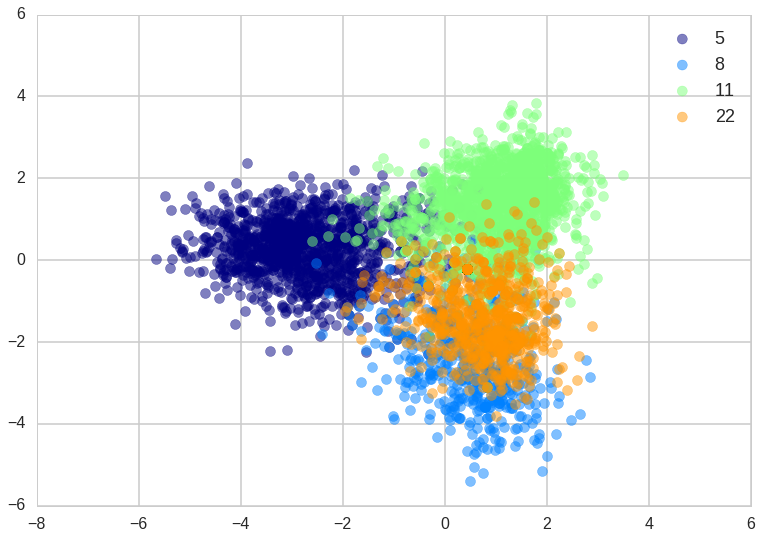

In [35]:
plot_list =[]
legend_text = []
nsteps=len(np.unique(labels))
cmap = cm.get_cmap('jet')

target_ix = (np.unique(y))#[2:4]
print target_ix

for i,author_index in enumerate(target_ix):
    data2d = X_r2[y==author_index]
    ploti = plt.scatter(data2d[:,0], data2d[:,1], color=cmap(i / float(nsteps)),s=100,alpha=0.5)
    plot_list.append(ploti)
    print author_index,labels[y==author_index][0]
    legend_text.append(author_index)
   
legend =plt.legend((plot_list),
           (legend_text),
           scatterpoints=1,
           loc='upper right',
           ncol=1,
           fontsize=18)

## PCA with simple word count

In [36]:
def word_count(df,author_name):
    df1 = df[df.author_name==author_name]
    content =df1.content.str.cat()
    words = re.split(r'\W+', content.lower())
    words = filter(lambda x: x.isalpha(), words)
    words = [word for word in words 
    if len(word) > 3 and word not in stop]
    
    word_count = Counter(words)
    return word_count

In [37]:
author_list =['The real greybeard','Iron Knee', 'christopher c','Francheska (Maya) Smith-Johnson',
 'Njegos',
 'maljoffre',
 'Paul A. Myers',
 "Paul Munton's Potimarron",
 'TylerDurden',
 'Harold Godwinson',
 'Ealing',
 'MarkGB',
 'rrrahul',
 'Harry Lime',
 'Gulliver',
 'Good European',
 'Judyw',
 'Don10984408',
 'Apostle',
 'RiskAdjustedReturn',
 'Ric']


In [38]:
word_df = pd.DataFrame()
for author in author_list:
    word_counter = word_count(df,author)
    word_count_df = pd.DataFrame.from_dict(word_counter,
                                     orient='index')
    word_count_df.ix[:, 0] = word_count_df.values.flatten() / float(word_count_df.values.sum())
    word_count_df.columns=[author]
    word_df = pd.merge(word_df,word_count_df,left_index=True,right_index=True,how='outer')

word_df = word_df.fillna(0)
print "Number of unique words: %s" % len(word_df)
word_df.head(12)

Number of unique words: 34425


,The real greybeard,Iron Knee,christopher c,Francheska (Maya) Smith-Johnson,Njegos,maljoffre,Paul A. Myers,Paul Munton's Potimarron,TylerDurden,Harold Godwinson,Ealing,MarkGB,rrrahul,Harry Lime,Gulliver,Good European,Judyw,Don10984408,Apostle,RiskAdjustedReturn,Ric
aaib,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000024,0.000000,0.000000,0.0,0.0
aamer,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000172,0.0,0.000000,0.000000,0.000000,0.0,0.0
aaron,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000019,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
aarsal,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000081,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
aawsat,0.0,0.0,0.000000,0.0,0.000031,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
aawy,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000063,0.000000,0.0,0.0
abaaoud,0.0,0.0,0.000107,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
abaaoudcould,0.0,0.0,0.000021,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
abacab,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000172,0.0,0.000000,0.000000,0.000071,0.0,0.0
aback,0.0,0.0,0.000000,0.0,0.000016,0.000022,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [39]:
data =word_df.T
data.shape

(21, 34425)

In [40]:
labels = data.index.values

In [41]:
pca = TruncatedSVD(n_components=15, random_state=42)
X = pca.fit_transform(data) 
X.shape

(21, 15)

In [42]:
print pca.explained_variance_ratio_.sum()

0.882416138527


In [43]:
pca.explained_variance_ratio_*100

array([  0.783,  16.186,  10.067,   9.26 ,   7.351,   6.82 ,   6.289,
         5.171,   4.935,   4.282,   4.048,   3.52 ,   3.314,   3.211,
         3.002])

In [44]:
df = pd.DataFrame({"name":labels})
for i in range(pca.explained_variance_ratio_.shape[0]):
    df["pc%i" % (i+1)] =X[:,i]

In [45]:
print labels.tolist()

['The real greybeard', 'Iron Knee', 'christopher c', 'Francheska (Maya) Smith-Johnson', 'Njegos', 'maljoffre', 'Paul A. Myers', "Paul Munton's Potimarron", 'TylerDurden', 'Harold Godwinson', 'Ealing', 'MarkGB', 'rrrahul', 'Harry Lime', 'Gulliver', 'Good European', 'Judyw', 'Don10984408', 'Apostle', 'RiskAdjustedReturn', 'Ric']


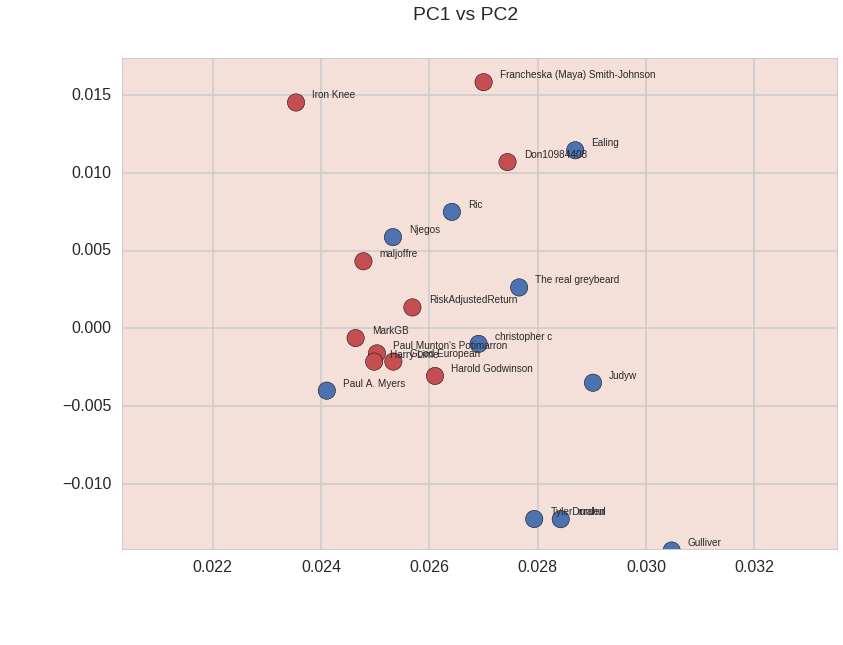

In [46]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]
colors = [c0, c2]

xmin,xmax = df['pc1'].min(),df['pc1'].max()
ymin,ymax = df['pc2'].min(),df['pc2'].max()

fig, ax = plt.subplots() 
ax.set_axis_bgcolor(BACKGROUND_COLOR)
fig.suptitle("PC1 vs PC2 ")
ax.scatter(df['pc1'], df['pc2'], c=colors,s=300)
ax.set_xlim(xmin*0.9, xmax*1.1)
ax.set_ylim(ymin*0.9,ymax*1.1)



for i, txt in enumerate(labels.tolist()):
    ax.annotate(txt, (df['pc1'].iloc[i]+.0003,df['pc2'].iloc[i]+.0008),fontsize=10,verticalalignment='top',horizontalalignment='left')
